In [234]:
import mlx.core as mx
import warnings
from functools import partial
import numpy as np

In [40]:
vocab_size = 4096
emb_dim = 2222

embedding_table = mx.random.normal([vocab_size, emb_dim])

def embed_token(embedding_table, tokens):
    return embedding_table[tokens]

@partial(mx.vmap, in_axes=(None, 0), out_axes=0) # slower for 1d tokens. Fast for 2d tokens (batched)
def embed_token_vmapped(embedding_table, tokens):
    return embed_token(embedding_table, tokens)

In [298]:
# RoPE

context_size = 100
emb_dim = 2222
base_theta = 10000.0
d = emb_dim

def precompute_rope_cos_sin(max_positions, emb_dim, base_theta=10000.0, stream=mx.cpu):
    d = emb_dim
    theta_i = mx.power(base_theta, (-2 * mx.divide(mx.arange(0, d // 2), d, stream=stream)), stream=stream)

    indices = mx.stack([mx.arange(0, d // 2)]*2).T.flatten() # (d,)
    positions = mx.arange(0, max_positions) # (max_positions,)
    pos_theta_i = mx.outer(positions, theta_i[indices], stream=stream) # (max_positions, d)
    cos = mx.cos(pos_theta_i, stream=stream) # (max_positions, d)
    sin = mx.sin(pos_theta_i, stream=stream) # (max_positions, d)
    return mx.expand_dims(cos, axis=0), mx.expand_dims(sin, axis=0) # (1, max_positions, d)

def apply_rope(q, k, cos, sin, expand_axis=1):
    """ Applies rope to q and k matrices.

    Why q and k, and not just x?
    The essense of RoPE method is to have __relative__ positional embeddings. The relative position information
    will only occur when we take dot product between the two embedded vectors, which is meant to be the step of
    Q @ K_T in the self-attention mechanism. We can just use single argument, but making it explicit here will
    prevent any confusion.

    Args:
        q: query matrix of shape (..., seq_len, dim)
        k: key matrix of shape (..., seq_len, dim)

    """
    def rearrange(x):
        """Rearrange the hidden dims of the input, according to the RoPE paper.
        
        From x1, x2, x3, x4, x5 ...
        To  -x2, x1,-x4, x3,-x6, x5, ...
        """
        x1 = x[..., : x.shape[-1] // 2]
        x2 = x[..., x.shape[-1] // 2 :]
        return mx.stack([-x2, x1], axis=-1).flatten(-2)
    
    seq_len = q.shape[-2]
    cos = cos[:seq_len, :]
    sin = sin[:seq_len, :]
    cos = mx.expand_dims(cos, axis=expand_axis)
    sin = mx.expand_dims(sin, axis=expand_axis)
    print(cos.shape, q.shape)
    q_pos_embed = (q * cos) + (rearrange(q) * sin)
    k_pos_embed = (k * cos) + (rearrange(k) * sin)
    return q_pos_embed, k_pos_embed




# Meta's implementation
# def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
#     import torch
#     freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
#     # print(freqs)
#     t = torch.arange(end, device=freqs.device, dtype=torch.float32)
#     # print(t)
#     freqs = torch.outer(t, freqs)
#     # print(freqs.shape)
#     freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
#     return freqs_cis

# cos, sin = precompute_rotary_emb_cos_sin(context_size, emb_dim, base_theta=base_theta)
# freqs_cis = precompute_freqs_cis(emb_dim, end=context_size, theta=base_theta)

# print(np.allclose(np.array(cos[:,::2]), freqs_cis.real.numpy(), atol=1e-5))
# print(np.allclose(np.array(sin[:,::2]), freqs_cis.imag.numpy(), atol=1e-5))
# cos, sin, freqs_cis.real, freqs_cis.imag

# (np.array(cos[:,::2]) - freqs_cis.real.numpy()).sum()

## ? forward

x = mx.random.normal([2, context_size, emb_dim])
cos, sin = precompute_rope_cos_sin(context_size, emb_dim, base_theta=base_theta)
x_pos_embed, _ = apply_rope(x, x, cos, sin)
x_pos_embed.shape

(1, 1, 100, 2222) (2, 100, 2222)


(1, 2, 100, 2222)

In [297]:
x = mx.arange(10).reshape(1, 1, 10)
def rearrange(x):
        """Rotates half the hidden dims of the input."""
        x1 = x[..., : x.shape[-1] // 2]
        x2 = x[..., x.shape[-1] // 2 :]
        
        return mx.stack([-x2, x1], axis=-1).flatten(-2)
y =rearrange(x)
y.shape

(1, 1, 10)

In [283]:
import torch
def create_rope_embed_ids(
    head_dim: int, 
    seq_len: int,
    device: torch.device,
    base: int = 10000,
):
    inv_freq = 1.0 / (
        base ** (torch.arange(0, head_dim, 2, device=device).float() / head_dim)
    )
    
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.einsum("i , j -> i j", t, inv_freq)
    emb = torch.cat([freqs, freqs], dim=-1)
    cos = emb.cos().unsqueeze(0)  # [1, seq_len, head_dim]
    sin = emb.sin().unsqueeze(0)  # [1, seq_len, head_dim]
    
    return cos, sin

cos, sin = create_rope_embed_ids(emb_dim, context_size, torch.device("cpu"))

In [284]:
cos.shape, sin.shape

(torch.Size([1, 100, 2222]), torch.Size([1, 100, 2222]))

In [285]:
cos.unsqueeze(1).shape

torch.Size([1, 1, 100, 2222])

In [190]:
############ Self-Attention
attn_dim = 333
context_size = 100
W_Q = mx.random.normal([attn_dim, emb_dim])
W_K = mx.random.normal([attn_dim, emb_dim])

# W_V = mx.random.normal([emb_dim, emb_dim]) # full V
W_V = mx.random.normal([attn_dim, emb_dim]) # V_down


W_O = mx.random.normal([emb_dim, attn_dim]) # V_up


# * Testing
mx.random.seed(0)
x = mx.random.normal([context_size, emb_dim])

Q = mx.matmul(x, W_Q.T) # (context_size, attn_dim) = [[q1], [q2], [q3]]
K = mx.matmul(x, W_K.T) # (context_size, attn_dim) = [[k1], [k2], [k3]]
V = mx.matmul(x, W_V.T) # (context_size, attn_dim) = [[v1], [v2], [v3]]
attn_score = mx.matmul(Q, K.T) # (context_size, context_size) = [[q1k1, q1k2, q1k3], [q2k1, q2k2, q2k3], [q3k1, q3k2, q3k3]]
attn_score = mx.softmax(attn_score / mx.sqrt(attn_dim), axis=-1)
delta_x_down = mx.matmul(attn_score, V) # (context_size, attn_dim) = [[q1k1v1 + q1k2v2 + q1k3v3], [q2k1v1 + q2k2v2 + q2k3v3], [q3k1v1 + q3k2v2 + q3k3v3]]

# attn_dim -> emb_dim
delta_x = mx.matmul(delta_x_down, W_O.T) # (context_size, emb_dim)
delta_x.shape

# residual
out1 = x + delta_x
out1.shape

(100, 2222)

In [191]:

tmp_attn_score = attn_score
tmp_delta_x_down = delta_x_down
tmp_delta_x = delta_x
tmp_W_Q = W_Q
tmp_W_K = W_K
tmp_W_V = W_V
tmp_W_O = W_O

In [192]:
############ Multi-head Self-Attention
num_heads = 2
attn_dim = 333
context_size = 100

W_Q = mx.random.normal([num_heads * attn_dim, emb_dim])
W_K = mx.random.normal([num_heads * attn_dim, emb_dim])

# W_V = mx.random.normal([emb_dim, emb_dim]) # full V
W_V = mx.random.normal([num_heads * attn_dim, emb_dim]) # V_down


W_O = mx.random.normal([emb_dim, num_heads * attn_dim]) # V_up

# Copy 1st head
W_Q[:attn_dim, :] = tmp_W_Q
W_K[:attn_dim, :] = tmp_W_K
W_V[:attn_dim, :] = tmp_W_V
W_O[:, :attn_dim] = tmp_W_O
W_O[:, attn_dim:] = 0. # Mute all other heads

# * Running
mx.random.seed(0)
x = mx.random.normal([context_size, emb_dim])

Q = mx.matmul(x, W_Q.T) # (context_size, num_heads * attn_dim) = [[q1], [q2], [q3]]
K = mx.matmul(x, W_K.T) # (context_size, num_heads * attn_dim) = [[k1], [k2], [k3]]
V = mx.matmul(x, W_V.T) # (context_size, num_heads * attn_dim) = [[v1], [v2], [v3]]

Q = Q.reshape(context_size, num_heads, attn_dim).transpose(1, 0, 2) # (num_heads, context_size, attn_dim)
K = K.reshape(context_size, num_heads, attn_dim).transpose(1, 0, 2) # (num_heads, context_size, attn_dim)
V = V.reshape(context_size, num_heads, attn_dim).transpose(1, 0, 2) # (num_heads, context_size, attn_dim)
# Q.shape
attn_score = mx.matmul(Q, K.transpose(0, -1, -2))
attn_score = mx.softmax(attn_score / mx.sqrt(attn_dim), axis=-1) # (num_heads, context_size, context_size)

delta_x_down = mx.matmul(attn_score, V) # (num_heads, context_size, attn_dim)
delta_x_down = delta_x_down.transpose(1, 0, 2).reshape(context_size, num_heads * attn_dim)

delta_x = mx.matmul(delta_x_down, W_O.T)

# Q.reshape(-1, num_heads, attn_dim).transpose(-2, 0, -1) # (num_head, context_size, attn_dim) 
# mx.stack(mx.split(Q, num_heads, axis=-1)).shape
# attn_score = mx.matmul(Q, K.T) # (context_size, context_size) = [[q1k1, q1k2, q1k3], [q2k1, q2k2, q2k3], [q3k1, q3k2, q3k3]]
# delta_x_down = mx.matmul(attn_score, V) # (context_size, attn_dim) = [[q1k1v1 + q1k2v2 + q1k3v3], [q2k1v1 + q2k2v2 + q2k3v3], [q3k1v1 + q3k2v2 + q3k3v3]]

# # attn_dim -> emb_dim
# delta_x = mx.matmul(delta_x_down, W_O) # (context_size, emb_dim)
# delta_x.shape

# residual
out2 = x + delta_x
out2.shape

(100, 2222)

In [196]:
delta_x, tmp_delta_x

(array([[-1018.81, 272.731, -1007.64, ..., 1441.65, 795.783, -1665.28],
        [-20.4744, -557.944, 1030.16, ..., -1546.48, -295.129, -1222.71],
        [48.7716, 916.096, 507.457, ..., -1636.86, 6.9795, -421.756],
        ...,
        [-1049.29, 1109.18, 1094.98, ..., -1612.33, -94.2552, -1105.67],
        [68.4834, -39.0533, 1451.22, ..., -1251.4, -132.051, 347.097],
        [-348.604, 1106.96, 942.691, ..., 625.168, -861.654, -1676.9]], dtype=float32),
 array([[-1018.81, 272.731, -1007.64, ..., 1441.65, 795.783, -1665.28],
        [-20.4744, -557.944, 1030.16, ..., -1546.48, -295.129, -1222.71],
        [48.7717, 916.096, 507.457, ..., -1636.86, 6.97953, -421.756],
        ...,
        [-1049.29, 1109.18, 1094.98, ..., -1612.33, -94.2557, -1105.67],
        [68.4836, -39.0533, 1451.22, ..., -1251.4, -132.051, 347.097],
        [-348.604, 1106.96, 942.691, ..., 625.168, -861.654, -1676.9]], dtype=float32))

In [193]:
mx.allclose(out1, out2)

(array(False, dtype=bool),
 array([[-1018.81, 272.731, -1007.64, ..., 1441.65, 795.783, -1665.28],
        [-20.4744, -557.944, 1030.16, ..., -1546.48, -295.129, -1222.71],
        [48.7716, 916.096, 507.457, ..., -1636.86, 6.9795, -421.756],
        ...,
        [-1049.29, 1109.18, 1094.98, ..., -1612.33, -94.2552, -1105.67],
        [68.4834, -39.0533, 1451.22, ..., -1251.4, -132.051, 347.097],
        [-348.604, 1106.96, 942.691, ..., 625.168, -861.654, -1676.9]], dtype=float32),
 array([[-1018.81, 272.731, -1007.64, ..., 1441.65, 795.783, -1665.28],
        [-20.4744, -557.944, 1030.16, ..., -1546.48, -295.129, -1222.71],
        [48.7717, 916.096, 507.457, ..., -1636.86, 6.97953, -421.756],
        ...,
        [-1049.29, 1109.18, 1094.98, ..., -1612.33, -94.2557, -1105.67],
        [68.4836, -39.0533, 1451.22, ..., -1251.4, -132.051, 347.097],
        [-348.604, 1106.96, 942.691, ..., 625.168, -861.654, -1676.9]], dtype=float32))

In [232]:
import mlx.core as mx

def test(device1, device2):
    mx.random.seed(0)
    a = mx.random.normal([100, 200], dtype=mx.float32, stream=mx.cpu) # random with same device
    b1 = mx.random.normal([200, 100], dtype=mx.float32, stream=mx.cpu)
    b1[100:, :] = 0  # make bottom half zero
    b2 = b1[:100, :] # b2 is the top half

    x1 = mx.matmul(a, b1, stream=device1)
    x2 = mx.matmul(a[:,:100], b2, stream=device2)
    print(mx.allclose(x1, x2, atol=1e-8, rtol=1e-5), mx.sum(x1-x2))

test(mx.cpu, mx.cpu)
test(mx.cpu, mx.gpu)
test(mx.gpu, mx.cpu)
test(mx.gpu, mx.gpu)

array(True, dtype=bool) array(0, dtype=float32)
array(False, dtype=bool) array(9.7126e-05, dtype=float32)
array(True, dtype=bool) array(0, dtype=float32)
array(False, dtype=bool) array(9.7126e-05, dtype=float32)


In [222]:
import numpy as np
np.random.seed(0)
a = np.random.normal(size = [100, 200]).astype(np.float32)
b1 = np.random.normal(size = [200, 100]).astype(np.float32)
b1[100:, :] = 0
b2 = b1[:100, :]

x1 = a @ b1
x2 = a[:,:100] @ b2
print(np.allclose(x1, x2, atol=1e-8, rtol=1e-5), x1.shape, x2.shape, np.sum(x1-x2))

True (100, 100) (100, 100) 0.0


In [130]:
mx.allclose(tmp_attn_score, attn_score[0])

array(True, dtype=bool)

In [150]:
attn_score[1].sum()

array(100, dtype=float32)

In [143]:
# mx.allclose(tmp_delta_x_down, delta_x_down[:, :attn_dim])
mx.allclose(W_O[:, :attn_dim], tmp_W_O)

array(True, dtype=bool)

In [118]:
mx.allclose(out1, out2)

array(False, dtype=bool)

In [103]:
mx.sum(attn_score[0], axis=0)

array([0, 2, 1, ..., 1, 1, 1], dtype=float32)

<Axes: >

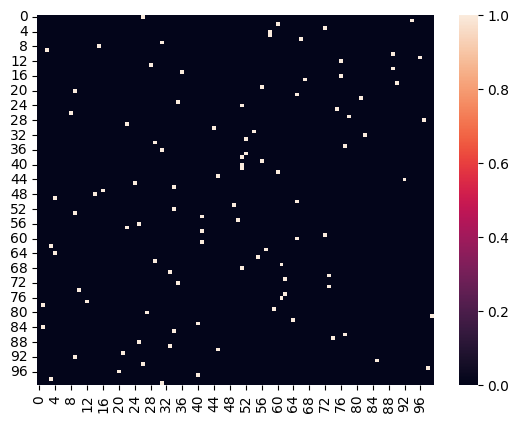

In [99]:
import seaborn as sns
import numpy as np
sns.heatmap(np.array(attn_score[0]))

<Axes: >

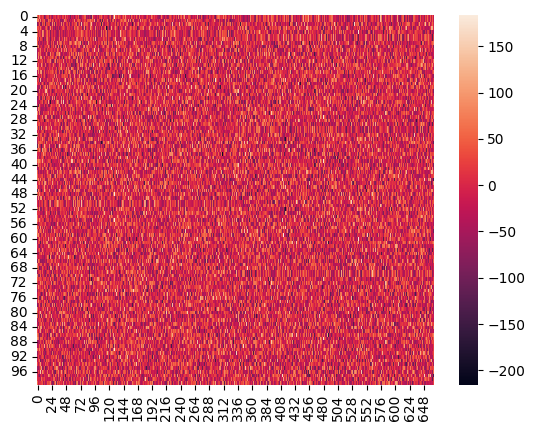

In [137]:
sns.heatmap(np.array(delta_x_down))

<Axes: >

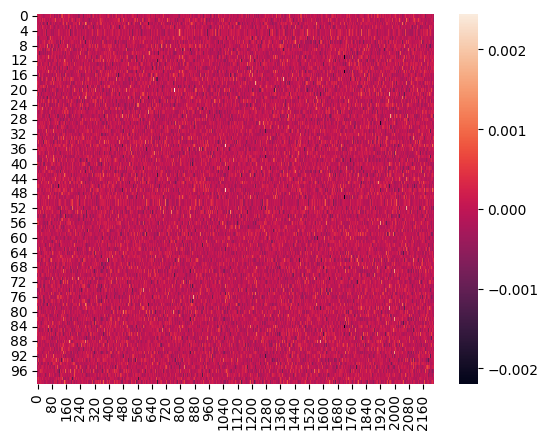

In [142]:
sns.heatmap(np.array(out1 - out2))
# sns.heatmap(np.array(W_O.T))

In [80]:
attn_score[0]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [13]:
embedding_table.shape

(4096, 2222)

In [14]:
sentence_length = 100
tokens = mx.random.randint(0, vocab_size, [sentence_length])

In [15]:
embed_token(embedding_table, tokens).shape

(100, 2222)

In [32]:
mx.eval(tokens)
embed_token_vmapped = mx.vmap(embed_token, in_axes=(None, 0), out_axes=0)
# %timeit embed_token_vmapped(embedding_table, mx.stack([tokens, tokens]))
%timeit mx.eval(embed_token_vmapped(embedding_table, tokens))
%timeit mx.eval(embed_token(embedding_table, tokens))

210 μs ± 22.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
172 μs ± 1.48 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [31]:
a=embed_token_vmapped(embedding_table, tokens)
b=embed_token(embedding_table, tokens)
mx.eval(a, b)
mx.allclose(a, b)

array(True, dtype=bool)

In [29]:
mx.allclose(mx.array([1, 2, 3]), mx.array([1, 2, 3]))

array(True, dtype=bool)

In [306]:
a = mx.array([1, 2, 3])
b = mx.stack([a] * 2).reshape(2, 3)
mx.concatenate([b]*1).shape

(2, 3)

In [21]:

import torch
weight_path = "../weights/checkpoints/Llama3.2-1B/consolidated.00.pth"
weights = torch.load(weight_path, map_location=torch.device("cpu"))

In [22]:
print('\n'.join(weights.keys()))

tok_embeddings.weight
layers.0.attention.wq.weight
layers.0.attention.wk.weight
layers.0.attention.wv.weight
layers.0.attention.wo.weight
layers.0.feed_forward.w1.weight
layers.0.feed_forward.w3.weight
layers.0.feed_forward.w2.weight
layers.0.attention_norm.weight
layers.0.ffn_norm.weight
layers.1.attention.wq.weight
layers.1.attention.wk.weight
layers.1.attention.wv.weight
layers.1.attention.wo.weight
layers.1.feed_forward.w1.weight
layers.1.feed_forward.w3.weight
layers.1.feed_forward.w2.weight
layers.1.attention_norm.weight
layers.1.ffn_norm.weight
layers.2.attention.wq.weight
layers.2.attention.wk.weight
layers.2.attention.wv.weight
layers.2.attention.wo.weight
layers.2.feed_forward.w1.weight
layers.2.feed_forward.w3.weight
layers.2.feed_forward.w2.weight
layers.2.attention_norm.weight
layers.2.ffn_norm.weight
layers.3.attention.wq.weight
layers.3.attention.wk.weight
layers.3.attention.wv.weight
layers.3.attention.wo.weight
layers.3.feed_forward.w1.weight
layers.3.feed_forward.w3.w

In [29]:
weights['layers.4.attention_norm.weight']

tensor([0.4141, 0.4258, 0.3613,  ..., 0.4199, 0.6016, 0.3887],
       dtype=torch.bfloat16)

In [24]:
weights['layers.0.ffn_norm.weight']

tensor([0.2041, 0.1992, 0.1846,  ..., 0.2139, 0.2021, 0.2080],
       dtype=torch.bfloat16)

In [312]:
weights['tok_embeddings.weight'].shape # (128256, 2048) vocab_size, emb_dim

torch.Size([128256, 2048])

In [313]:
weights['layers.0.attention.wq.weight'].shape # (2048, 2048) num_heads * attn_dim, emb_dim

torch.Size([2048, 2048])

In [314]:
weights['layers.0.attention.wk.weight'].shape # (512, 2048) num_kv_heads * attn_dim, emb_dim

torch.Size([512, 2048])

In [326]:
weights['layers.0.feed_forward.w1.weight'].shape # (8192, 2048) ffn_hidden_dim, emb_dim
weights['layers.0.feed_forward.w2.weight'].shape # (2048, 8192) emb_dim, ffn_hidden_dim
weights['layers.0.feed_forward.w3.weight'].shape # (8192, 2048) ffn_hidden_dim, emb_dim

torch.Size([8192, 2048])

In [323]:
weights['norm.weight'].shape # (2048,)

torch.Size([2048])

In [328]:
from llama_models.llama3.api import Tokenizer
tokenizer_path = "../weights/checkpoints/Llama3.2-1B/tokenizer.model"
tokenizer = Tokenizer(tokenizer_path)

In [332]:
tokenizer.encode("Hello, world!", bos=True, eos=True)

[128000, 9906, 11, 1917, 0, 128001]

In [338]:
# @partial(mx.vmap, in_axes=(None, 0, None), out_axes=0)
@mx.compile
def element_wise_add(a, b, bias):
    return a + b + bias

a = mx.array([1, 2, 3])
b = mx.array([1, 2, 3])
element_wise_add(a, b, 1)

array([3, 5, 7], dtype=int32)

In [357]:
seq_len = 5
mask = mx.triu(mx.ones((seq_len, seq_len), dtype=mx.float32)* -mx.inf, k=1)
mask

array([[0, -inf, -inf, -inf, -inf],
       [0, 0, -inf, -inf, -inf],
       [0, 0, 0, -inf, -inf],
       [0, 0, 0, 0, -inf],
       [0, 0, 0, 0, 0]], dtype=float32)

In [352]:
torch.triu(torch.ones((seq_len, seq_len), dtype=torch.float32)* -torch.inf, diagonal=1)

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

In [355]:
seqlen = seq_len
mask = torch.full((seqlen, seqlen), float("-inf"))

mask = torch.triu(mask, diagonal=1)

# When performing key-value caching, we compute the attention scores
# only for the new sequence. Thus, the matrix of scores is of size
# (seqlen, cache_len + seqlen), and the only masked entries are (i, j) for
# j > cache_len + i, since row i corresponds to token cache_len + i.
mask = torch.hstack(
    [torch.zeros((seqlen, 0)), mask]
)
mask

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

In [364]:
tokenizer.encode("Hello", bos=True, eos=True)

[128000, 9906, 128001]

In [373]:
mx.random.categorical(mx.array([0.1, 0.9]), axis=-1)

array(0, dtype=uint32)

In [1]:
import os
from ref_model import Transformer, ModelArgs
import json
os.environ['_MODEL_PARALLEL_GROUP']='1'
hparams_path = "../weights/checkpoints/Llama3.2-1B/params.json"
with open(hparams_path) as f:
    hparams = json.load(f)
params = ModelArgs(**hparams)
model = Transformer(params)
weights = torch.load("../weights/checkpoints/Llama3.2-1B/weights.pt")
model.load_state_dict(weights)
model.eval()

AssertionError: model parallel group is not initialized

In [19]:
import mlx.core as mx

def precompute_rope_cos_sin(max_positions, attn_dim, base_theta=10000.0, use_scaled_rope=True, stream=mx.cpu):
    d = attn_dim
    theta_i = mx.power(
        base_theta, (-2 * mx.divide(mx.arange(0, d // 2), d, stream=stream)), stream=stream)

    # if use_scaled_rope:
    #     from ref_impl import apply_rope_scaling
    #     theta_i = apply_rope_scaling(theta_i)
    indices = mx.stack([mx.arange(0, d // 2)]*2).T.flatten()  # (d,)
    positions = mx.arange(0, max_positions)  # (max_positions,)
    # (max_positions, d)
    pos_theta_i = mx.outer(positions, theta_i[indices], stream=stream)
    cos = mx.cos(pos_theta_i, stream=stream)  # (max_positions, d)
    sin = mx.sin(pos_theta_i, stream=stream)  # (max_positions, d)
    # (1, max_positions, d)
    return mx.expand_dims(cos, axis=0), mx.expand_dims(sin, axis=0)

def apply_rope(q, k, cos, sin, expand_axis=2):
    """ Applies rope to q and k matrices.

    Why q and k, and not just x?
    The essense of RoPE method is to have __relative__ positional embeddings. The relative position information
    will only occur when we take dot product between the two embedded vectors, which is meant to be the step of
    Q @ K_T in the self-attention mechanism. We can just use single argument, but making it explicit here will
    prevent any confusion.

    Args:
        q: query matrix of shape (..., seq_len, dim)
        k: key matrix of shape (..., seq_len, dim)

    """
    def rearrange(x):
        """Rearrange the hidden dims of the input, according to the RoPE paper.

        From x1, x2, x3, x4, x5 ...
        To  -x2, x1,-x4, x3,-x6, x5, ...
        """
        # x1 = x[..., : x.shape[-1] // 2]
        # x2 = x[..., x.shape[-1] // 2:]
        x1 = x[..., ::2]
        x2 = x[..., 1::2]
        return mx.stack([-x2, x1], axis=-1).flatten(-2)

    seq_len = q.shape[-2]
    cos = cos[:, :seq_len, :]  # (bsz, seq_len, attn_dim)
    sin = sin[:, :seq_len, :]  # (bsz, seq_len, attn_dim)
    cos = mx.expand_dims(cos, axis=1)#.transpose(0, 2, 1, 3)
    sin = mx.expand_dims(sin, axis=1)#.transpose(0, 2, 1, 3)
    print(cos.shape, q.shape)
    # print(cos.shape, q.shape)
    q_pos_embed = (q * cos) + (rearrange(q) * sin)
    k_pos_embed = (k * cos) + (rearrange(k) * sin)
    return q_pos_embed, k_pos_embed
cos, sin = precompute_rope_cos_sin(200, 6, 500_000)
xq = mx.array([[[[1, 2, 3, 4, 5, 6]]*10]*2])
xk = mx.array([[[[1, 2, 3, 4, 5, 6]]*10]*2])
xq, xk = apply_rope(xq, xk, cos, sin)
print(xq[:,0,:,-1], xq.shape)

(1, 1, 10, 6) (1, 2, 10, 6)
array([[6, 6.00079, 6.00159, ..., 6.00555, 6.00634, 6.00714]], dtype=float32) (1, 2, 10, 6)


In [18]:
for x in xq[:,0,:,-1][0]:
    print(x)

array(6, dtype=float32)
array(6.0001, dtype=float32)
array(6.0002, dtype=float32)
array(6.0003, dtype=float32)
array(6.0004, dtype=float32)
array(6.0005, dtype=float32)
array(6.00059, dtype=float32)
array(6.00069, dtype=float32)
array(6.00079, dtype=float32)
array(6.00089, dtype=float32)


In [32]:
cos.shape

(1, 200, 6)

In [33]:
freqs_cis.shape

torch.Size([200, 3])

In [ ]:
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


In [20]:
import torch
import math

def apply_scaling(freqs: torch.Tensor):
    # Values obtained from grid search
    scale_factor = 8
    low_freq_factor = 1
    high_freq_factor = 4
    old_context_len = 8192  # original llama3 length

    low_freq_wavelen = old_context_len / low_freq_factor
    high_freq_wavelen = old_context_len / high_freq_factor
    new_freqs = []
    for freq in freqs:
        wavelen = 2 * math.pi / freq
        if wavelen < high_freq_wavelen:
            new_freqs.append(freq)
        elif wavelen > low_freq_wavelen:
            new_freqs.append(freq / scale_factor)
        else:
            assert low_freq_wavelen != high_freq_wavelen
            smooth = (old_context_len / wavelen - low_freq_factor) / (
                high_freq_factor - low_freq_factor
            )
            new_freqs.append((1 - smooth) * freq / scale_factor + smooth * freq)
    return torch.tensor(new_freqs, dtype=freqs.dtype, device=freqs.device)

def precompute_freqs_cis(
    dim: int, end: int, theta: float = 10000.0, use_scaled: bool = False
):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    if use_scaled:
        freqs = apply_scaling(freqs)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)


def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
):
    seq_len = xq.shape[1]
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis[:seq_len,:], xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)
xq = torch.tensor([[[[1, 2, 3, 4, 5, 6]]*2]*10], dtype=torch.float32)
xk = torch.tensor([[[[1, 2, 3, 4, 5, 6]]*2]*10], dtype=torch.float32)
freqs_cis = precompute_freqs_cis(6, end=200, theta=500000, use_scaled=True)
xq, xk = apply_rotary_emb(xq, xk, freqs_cis)
print(xq[:, :, 0, :], xq.shape)

tensor([[[ 1.0000,  2.0000,  3.0000,  4.0000,  5.0000,  6.0000],
         [-1.1426,  1.9221,  2.9494,  4.0375,  4.9999,  6.0001],
         [-2.2347,  0.0770,  2.8983,  4.0743,  4.9998,  6.0002],
         [-1.2722, -1.8389,  2.8467,  4.1105,  4.9996,  6.0003],
         [ 0.8600, -2.0641,  2.7947,  4.1460,  4.9995,  6.0004],
         [ 2.2015, -0.3916,  2.7422,  4.1809,  4.9994,  6.0005],
         [ 1.5190,  1.6409,  2.6893,  4.2151,  4.9993,  6.0006],
         [-0.5601,  2.1648,  2.6360,  4.2487,  4.9992,  6.0007],
         [-2.1242,  0.6984,  2.5823,  4.2816,  4.9990,  6.0008],
         [-1.7354, -1.4101,  2.5281,  4.3138,  4.9989,  6.0009]]]) torch.Size([1, 10, 2, 6])
